In [83]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [84]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



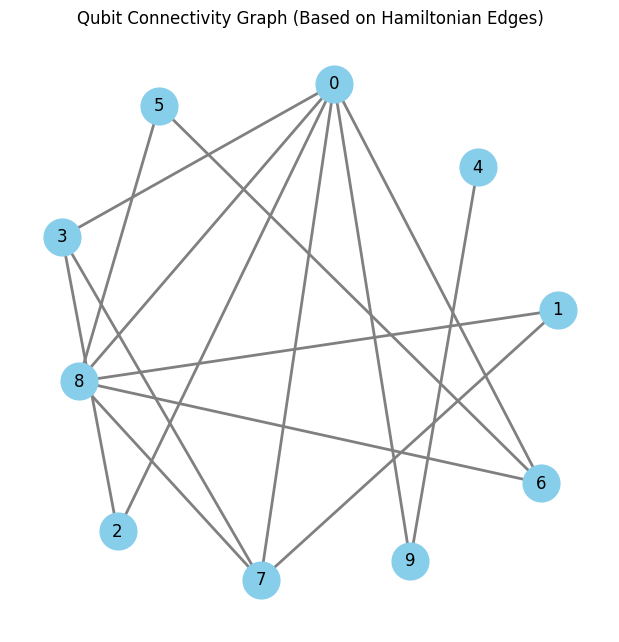

In [85]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 4
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [86]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [ ]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-6, max_iter=500):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi,pdim)  # Initial guess
solnm, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", solnm)
print("[Nelder-Mead] Iterations:", iters)


In [20]:
# Optimising using SPSA algorithm
a = 0.7
c = 0.1
A = 80
alpha = 0.602
gamma = 0.101
f_history = []

# Initial point
#theta =np.random.uniform(0, 3*np.pi, size=(n_layers*n_qubits))
theta=np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)
max_iterations = 1000
tolerance = 1e-6
np.random.seed(42)

for k in range(max_iterations):
    ak = a / (A + k + 1)**alpha
    ck = c / (k + 1)**gamma
    delta = np.random.choice([-1, 1], size=pdim)  #perturbation vector Δ_k from Bernoulli(±1)
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    y_plus = cost(theta_plus)
    y_minus = cost(theta_minus)
    g_hat = (y_plus - y_minus) / (2 * ck) * (1.0 / delta)
    theta = theta - ak * g_hat
    f_val = cost(theta)
    f_history.append(f_val)
    if k > 1 and abs(f_history[-1] - f_history[-2]) < tolerance and abs(f_history[-2] - f_history[-3]) < tolerance:
        break
print("[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", f_val)
print("[SPSA] Optimal θ:", theta)
solspsa = theta
print("[SPSA] Iterations:", len(f_history))
print(f_history)


[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.6171391178300514
[SPSA] Optimal θ: [ 1.09478994e+00  5.91501714e+00  4.77049991e+00  5.19195642e+00
  6.52721598e+00  1.43305093e+00  5.12553642e+00  1.71969050e+00
  4.71708175e+00  2.11115693e+00  6.33630948e+00  2.05640256e+00
  1.57344026e+00  4.89883366e+00  2.97330230e+00  3.38512281e+00
  3.11581270e+00  3.89101272e+00  8.26581574e-03  4.12182954e-02
  1.36943183e+00  2.77784731e+00  1.26921998e+00  1.83409422e+00
  2.28565650e+00 -7.14655415e-01  3.51479539e+00  4.94272035e+00
  3.66891523e-03  3.73034331e+00  4.63294389e+00  3.09586712e+00
  3.64407585e+00  1.60609007e+00  2.33841914e+00  4.95570302e-01
  4.72136008e+00  4.74606041e+00 -1.53025600e+00  1.59599649e+00]
[SPSA] Iterations: 513
[0.25307854595351104, 0.21810897923858477, 0.17514854257699716, 0.10791092834076457, -0.4718374721998866, -0.5261681280598878, -0.5374659323080295, -0.5397858108412809, -0.5565045838331704, -0.5599208144904261, -0.578691043160106, -0.8622129591197059, 

In [56]:
solspsa=[ 1.09478994e+00 , 5.91501714e+00  ,4.77049991e+00,  5.19195642e+00,
  6.52721598e+00 , 1.43305093e+00 , 5.12553642e+00 , 1.71969050e+00,
  4.71708175e+00 , 2.11115693e+00 , 6.33630948e+00  ,2.05640256e+00,
  1.57344026e+00 , 4.89883366e+00 , 2.97330230e+00 , 3.38512281e+00,
  3.11581270e+00  ,3.89101272e+00 , 8.26581574e-03 , 4.12182954e-02,
  1.36943183e+00 , 2.77784731e+00 , 1.26921998e+00 , 1.83409422e+00,
  2.28565650e+00 ,-7.14655415e-01 , 3.51479539e+00 , 4.94272035e+00,
  3.66891523e-03 , 3.73034331e+00 , 4.63294389e+00  ,3.09586712e+00,
  3.64407585e+00 , 1.60609007e+00 , 2.33841914e+00  ,4.95570302e-01,
  4.72136008e+00 , 4.74606041e+00 ,-1.53025600e+00  ,1.59599649e+00]

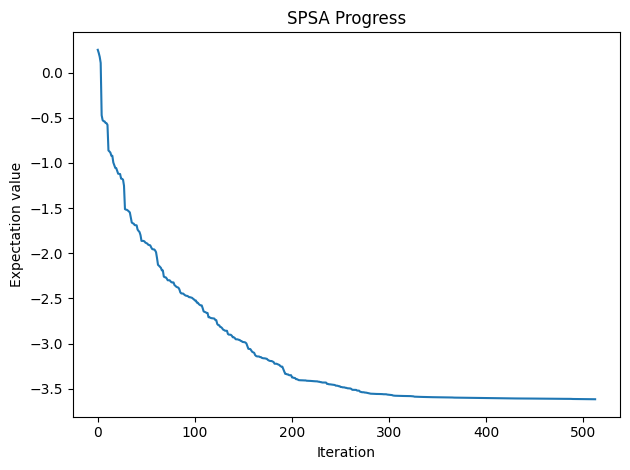

In [21]:
plt.plot(f_history)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('SPSA Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [7]:
#Optimising using L-BFGS algorithm
def lbfgs(f, grad_f, x0, m=100, tol=1e-6, max_iter=1000):
    x = x0.copy()
    k = 0  # iteration counter
    s_list = []   
    y_list = []   
    rho_list = [] 
    g = grad_f(x)
    f_histry = []
    BOUND = 0  # number of updates used
    while np.linalg.norm(g) > tol and k < max_iter:
        q = g.copy()
        alpha = []
        if k < m:
            INCR = 0
            BOUND = k
        else:
            INCR = k - m
            BOUND = m
        for i in range(BOUND - 1, -1, -1):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            alpha_i = rho * np.dot(s, q)
            alpha.append(alpha_i)
            q = q - alpha_i * y

        alpha = alpha[::-1]  # to use in forward loop later

        if len(y_list) > 0:
            y_last = y_list[-1]
            s_last = s_list[-1]
            gamma = np.dot(s_last, y_last) / np.dot(y_last, y_last)
        else:
            gamma = 1.0
        r = gamma * q
        for i in range(0, BOUND):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            beta = rho * np.dot(y, r)
            r = r + s * (alpha[i] - beta)

        #search direction and backtracking line search
        p = -r
        t = 1.0
        while f(x + t * p) > f(x) + 1e-4 * t * np.dot(g, p):
            t *= 0.5
            if t < 1e-10:
                break
        #position and gradient update
        x_new = x + t * p
        g_new = grad_f(x_new)
        s_k = x_new - x
        y_k = g_new - g

        #store s_k, y_k, and ρ_k if curvature condition satisfied
        if np.dot(s_k, y_k) > 1e-10:
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(1.0 / np.dot(y_k, s_k))

            #maintaining memory size
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

        x = x_new
        g = g_new
        k += 1
        f_histry.append(f(x))
        #print(f"Iter {k:2d} | f(x) = {f(x):.6f} | ||grad|| = {np.linalg.norm(g):.2e}") 
    return x, f(x), k , f_histry


In [8]:
#writing a function grad that calculates gradient numerically 
def grad_numerical(func, v, h=1e-3):
    grad = np.zeros_like(v)
    for i in range(len(v)):
        v_plus = np.copy(v)
        v_minus = np.copy(v)
        v_plus[i] += h
        v_minus[i] -= h
        grad[i] = (func(v_plus) - func(v_minus)) / (2 * h)
    return grad

In [9]:
x0 =np.random.uniform(0, 2 * np.pi, pdim)  # Initial guess
solbfgs,fvalue,niter ,fhist= lbfgs(cost , lambda x: grad_numerical(cost, x), x0)
print("[L-BFGS] Optimal θ: ",solbfgs) 
print("[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: ",fvalue)
print("[L-BFGS] Iterations:", niter)
print(fhist)

[L-BFGS] Optimal θ:  [-8.84148177e-08  3.13325373e+00  3.80106343e+00  4.71240737e+00
  6.06984548e+00  2.98119356e+00  5.50228549e+00  5.75156742e+00
  1.57079660e+00  1.18597559e+00  3.14159253e+00  3.10837784e+00
  3.80106266e+00  4.63799132e+00  4.89270785e+00  2.40440959e+00
  4.18318524e-01  4.84589562e+00  3.14159304e+00  6.10649662e+00
 -6.97801068e-09  6.24509393e+00  1.18487774e-05  1.28458091e+00
  7.59222748e-01  6.04226484e+00  5.80628482e+00  2.26539886e+00
  6.28318490e+00  3.52010679e+00  3.14159265e+00  6.33246668e+00
  3.14159279e+00  2.82563552e+00  5.32137923e+00  5.84489559e+00
  5.47955713e+00  4.06171642e+00 -1.57079571e+00  5.40994954e+00]
[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:  -3.6596101690330665
[L-BFGS] Iterations: 57
[-1.3460106848146904, -1.951280728437424, -2.1052459760421756, -2.8381996339422946, -3.046924865876451, -3.133760304813999, -3.187855963102188, -3.2843998571531814, -3.3577755613740483, -3.4710816986395683, -3.575373580742591, -3.610194140762629

In [6]:
solbfgs=[-8.84148177e-08 , 3.13325373e+00,  3.80106343e+00,  4.71240737e+00,
  6.06984548e+00  ,2.98119356e+00 , 5.50228549e+00 , 5.75156742e+00,
  1.57079660e+00 , 1.18597559e+00 , 3.14159253e+00 , 3.10837784e+00,
  3.80106266e+00 , 4.63799132e+00 , 4.89270785e+00 , 2.40440959e+00,
  4.18318524e-01 , 4.84589562e+00 , 3.14159304e+00 , 6.10649662e+00,
 -6.97801068e-09 , 6.24509393e+00 , 1.18487774e-05 , 1.28458091e+00,
  7.59222748e-01 , 6.04226484e+00 , 5.80628482e+00 , 2.26539886e+00,
  6.28318490e+00 , 3.52010679e+00 , 3.14159265e+00 , 6.33246668e+00,
  3.14159279e+00 , 2.82563552e+00,  5.32137923e+00  ,5.84489559e+00,
  5.47955713e+00 , 4.06171642e+00 ,-1.57079571e+00  ,5.40994954e+00]

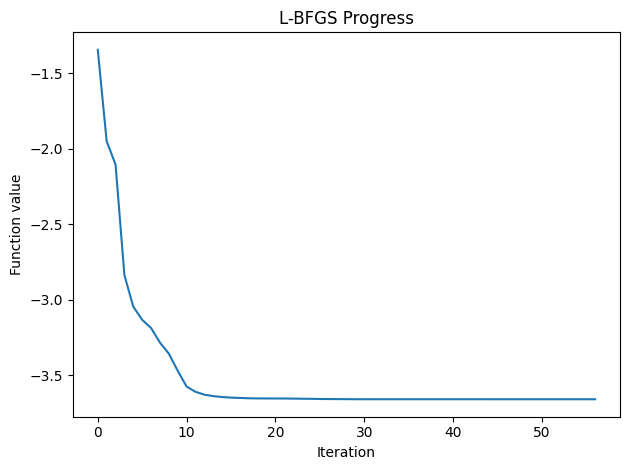

In [17]:
plt.plot(fhist)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('L-BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [11]:
#Optimizing using Adam algorithm
def adam_optimize(func, grad, theta_init, alpha=0.3, beta1=0.9, beta2=0.999,epsilon=1e-8, max_iters=500, tolerance=1e-6):
    theta = theta_init.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)

    thetas = [theta.copy()]
    losses = [func(theta)]
    f_history = []
    for t in range(1, max_iters + 1):
        g = grad_numerical(func, theta)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        f_val = func(theta)
        thetas.append(theta.copy())
        losses.append(f_val)
        f_history.append(f_val)
        # Early stopping based on function change
        if abs(losses[-1] - losses[-2]) < tolerance:
                #print(f"[Adam] Early stopping at iteration {t}: Δf = {abs(losses[-1] - losses[-2]):.2e} < {tolerance}")
                break

    return theta, losses, thetas, f_history


In [12]:

theta_init = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess for θ
soladam, loss_history, theta_path,fhistory = adam_optimize(cost, lambda x: grad_numerical(cost, x), theta_init)
print(f"[Adam] Optimal θ: {soladam}")
print(f"[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: {loss_history[-1]:.6f}") 
print(f"[Adam] Iterations: {len(loss_history)}")
print(fhistory)

[Adam] Optimal θ: [ 3.15245441e+00  6.19066414e+00  3.13004495e+00  2.64987448e+00
  1.29994036e+00  2.76974589e+00  1.39524736e+00  4.71097286e+00
  4.71426139e+00 -1.79204626e+00  6.28612376e+00  3.13851393e+00
  2.99011925e+00  2.05913834e+00  4.03170523e+00  4.62520999e+00
  3.10426998e+00  3.13952274e+00  1.38292441e-03  3.15237866e+00
 -8.91592221e-03  1.33238901e+00  6.13000668e+00  4.81751938e+00
  1.01373714e-01  1.98539185e+00  5.02213279e+00  6.28450324e+00
  6.28241967e+00  5.66457687e+00  3.14272589e+00  4.37881261e+00
  1.04446441e-02  3.04110870e+00  3.50264678e+00  2.99452563e+00
  6.58700839e+00  4.71240202e+00  1.56888581e+00  2.06435941e+00]
[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.456620
[Adam] Iterations: 107
[-1.0228428760453383, -1.1826576709032355, -1.8100153805557495, -2.3899417305514694, -2.6489897020826048, -2.853849089915623, -2.850426797118304, -2.8367075687964425, -2.897900137620045, -2.979965107380571, -3.073226812017741, -3.189132340398746, -3.240755033390

In [57]:
soladam=[ 3.15245441e+00,  6.19066414e+00 , 3.13004495e+00,  2.64987448e+00,
  1.29994036e+00 , 2.76974589e+00 , 1.39524736e+00 , 4.71097286e+00,
  4.71426139e+00 ,-1.79204626e+00 , 6.28612376e+00 , 3.13851393e+00,
  2.99011925e+00 , 2.05913834e+00 , 4.03170523e+00 , 4.62520999e+00,
  3.10426998e+00 , 3.13952274e+00 , 1.38292441e-03 , 3.15237866e+00,
 -8.91592221e-03 , 1.33238901e+00 , 6.13000668e+00 , 4.81751938e+00,
  1.01373714e-01 , 1.98539185e+00 , 5.02213279e+00 , 6.28450324e+00,
  6.28241967e+00 , 5.66457687e+00 , 3.14272589e+00 , 4.37881261e+00,
  1.04446441e-02 , 3.04110870e+00 , 3.50264678e+00 , 2.99452563e+00,6.58700839e+00  ,4.71240202e+00 , 1.56888581e+00 , 2.06435941e+00]

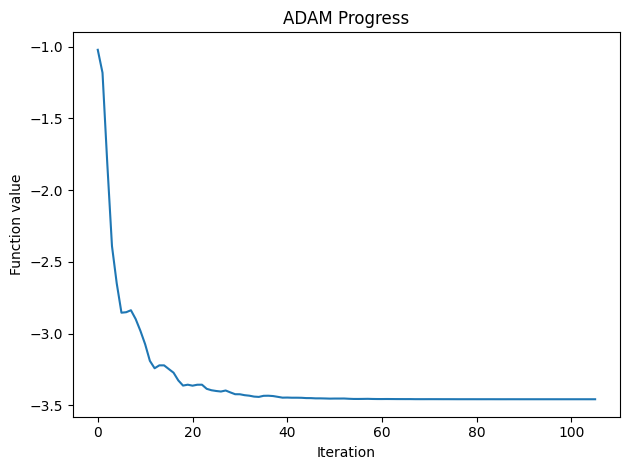

In [16]:
plt.plot(fhistory)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('ADAM Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

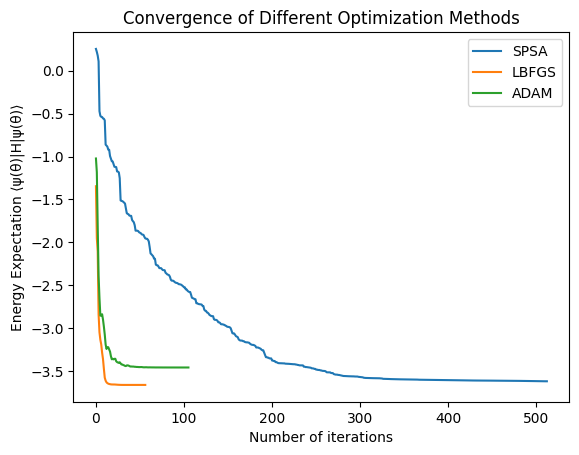

In [22]:
import matplotlib.pyplot as plt

#y1 = fhisto
y2 = f_history
y3 = fhist
y4 = fhistory

# Generate corresponding x-values automatically
#x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
x3 = list(range(len(y3)))
x4 = list(range(len(y4)))

# Plot each with its own x
#plt.plot(x1, y1, label='Nelder Mead')
plt.plot(x2, y2, label='SPSA')
plt.plot(x3, y3, label='LBFGS')
plt.plot(x4, y4, label='ADAM')

plt.xlabel('Number of iterations')
plt.ylabel('Energy Expectation ⟨ψ(θ)|H|ψ(θ)⟩')
plt.title('Convergence of Different Optimization Methods')
plt.legend()
plt.grid(False)
plt.show()



In [145]:
# After optimization
theta=soladam
state = ansatz(theta, n_qubits, edges, n_layers)
probs = np.abs(state)**2
sorted_probs = sorted(probs, reverse=True)

print("Top 5 probabilities:")
for i in range(5):
    print(f"{i+1}: {sorted_probs[i]:.6f}")


Top 5 probabilities:
1: 0.999982
2: 0.000009
3: 0.000001
4: 0.000001
5: 0.000001


In [144]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    #assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings
theta = soladam # example parameters
state = ansatz(theta, n_qubits, edges, n_layers)
probs = np.abs(state)**2
print("Max probability:", np.max(probs))
print("Non-zero probabilities:", np.sum(probs > 1e-3))
bitstrings = sample_bitstrings(state , 1000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))

Max probability: 0.9999822571718052
Non-zero probabilities: 1
['0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011', '0011001011',

In [140]:
def hamiltonian(n_qubits, seed):
    np.random.seed(seed)
    # Build symbolic Hamiltonian: (weight, [i, j]) for ZZ terms
    weights2 = [round(x, 3) for x in weights]
    hamiltonian_terms = [(weights[k], [i, j]) for k, (i, j) in enumerate(edges)]
    return hamiltonian_terms
hamiltonian_terms=hamiltonian(n_qubits, seed) 

In [141]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val


Estimated ⟨H⟩ = -3.456637931815621


In [142]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)


[('0011001011', 1000, -3.4566379318155622)]


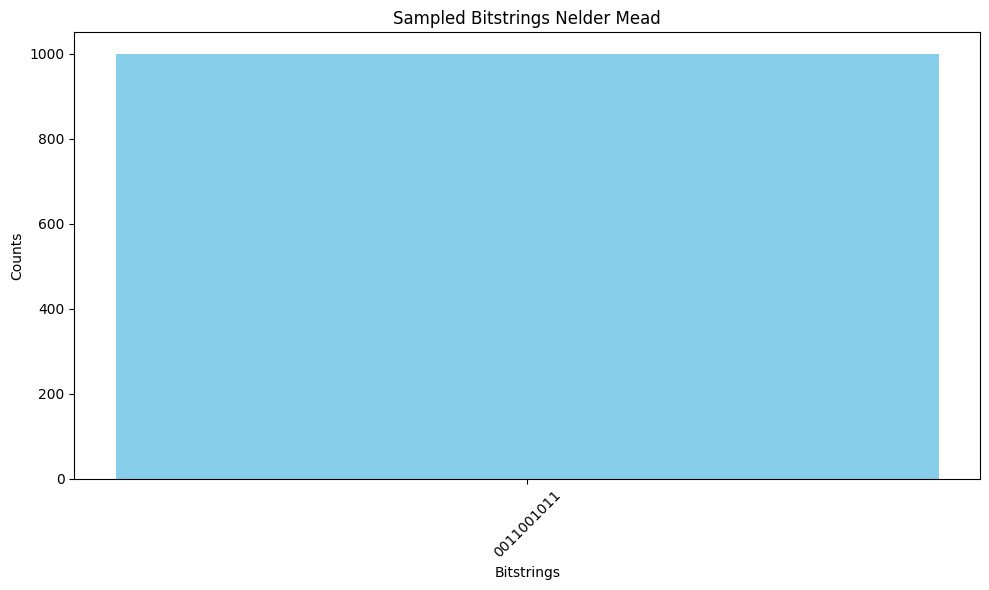

In [143]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstrings Nelder Mead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
